In [ ]:
import requests
import csv

# Replace 'your_token' with your personal access token
headers = {'Authorization': 'token your_token'}

def clean_company_name(company_name):
    if company_name:
        company_name = company_name.strip().lstrip('@').upper()
    return company_name

def fetch_users():
    users = []
    page = 1
    while True:
        params = {
            'q': 'location:dublin followers:>50',
            'sort': 'followers',
            'order': 'desc',
            'per_page': 100,
            'page': page
        }
        response = requests.get('https://api.github.com/search/users', headers=headers, params=params)
        if response.status_code != 200:
            break
        page_users = response.json().get('items', [])
        if not page_users:
            break
        users.extend(page_users)
        page += 1
    return users

def fetch_user_details(login):
    user_response = requests.get(f'https://api.github.com/users/{login}', headers=headers)
    if user_response.status_code == 200:
        return user_response.json()
    return {}

def fetch_repos(login):
    repos = []
    repos_response = requests.get(f'https://api.github.com/users/{login}/repos', headers=headers, params={'per_page': 500, 'sort': 'pushed'})
    if repos_response.status_code == 200:
        repos = repos_response.json()
    return repos

def convert_boolean(value):
    if value is None or value == '':
        return ''
    elif value is True:
        return 'true'
    elif value is False:
        return 'false'
    return value

def create_users_csv(users):
    with open('users.csv', mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(['login', 'name', 'company', 'location', 'email', 'hireable', 'bio', 'public_repos', 'followers', 'following', 'created_at'])
        for user in users:
            writer.writerow([
                user['login'],
                user.get('name', ''),
                clean_company_name(user.get('company', '')),
                user.get('location', ''),
                user.get('email', ''),
                convert_boolean(user.get('hireable', '')),
                user.get('bio', ''),
                user['public_repos'],
                user['followers'],
                user['following'],
                user['created_at']
            ])

def create_repos_csv(users):
    with open('repositories.csv', mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(['login', 'full_name', 'created_at', 'stargazers_count', 'watchers_count', 'language', 'has_projects', 'has_wiki', 'license_name'])
        for user in users:
            repos = fetch_repos(user['login'])
            for repo in repos:
                license_name = repo.get('license', {}).get('key', '') if repo.get('license') else ''
                writer.writerow([
                    user['login'],
                    repo['full_name'],
                    repo['created_at'],
                    repo['stargazers_count'],
                    repo['watchers_count'],
                    repo.get('language', ''),
                    convert_boolean(repo['has_projects']),
                    convert_boolean(repo['has_wiki']),
                    license_name
                ])

def main():
    users = fetch_users()
    detailed_users = [fetch_user_details(user['login']) for user in users]
    create_users_csv(detailed_users)
    create_repos_csv(detailed_users)

if __name__ == '__main__':
    main()

In [ ]:
import pandas as pd
users_df = pd.read_csv('users.csv')
users_df

,login,name,company,location,email,hireable,bio,public_repos,followers,following,created_at
0,orta,Orta Therox,NaN,Huddersfield / NYC / Dublin / Rio de Janeiro,git@orta.io,NaN,Tech on @puzzmo-com \r\n\r\nEx-TypeScript. Con...,952,6017,109,2009-01-24T20:40:31Z
1,jeromeetienne,Jerome Etienne,MAKING WEBAR A REALITY,"Dublin, Ireland",jerome.etienne@gmail.com,True,Making WebAR a reality - Around Javascript and...,301,2780,15,2010-04-26T11:58:29Z
2,jonataslaw,Jonny Borges,IRIS,"Dublin, Ireland",NaN,True,VP of Engineering from Iris Finance.\r\nDevelo...,272,2692,17,2018-01-23T19:17:15Z
3,steventroughtonsmith,Steven Troughton-Smith,HIGH CAFFEINE CONTENT,"Dublin, Ireland",NaN,NaN,NaN,98,1984,4,2009-01-08T23:51:31Z
4,axic,Alex Beregszaszi,ETHEREUM @IPSILON @SPEARBIT @ETHEREUMJS,"Dublin, Ireland",NaN,True,Works on decentralised stuff.\r\n\r\neipnft:ax...,143,1807,5,2008-08-11T23:38:10Z
...,...,...,...,...,...,...,...,...,...,...,...
472,10xOXR,Chris Quinn,MASTERCARD IRELAND,"Dublin, Ireland",NaN,NaN,Hardware/networking geek now working in softwa...,21,51,33,2018-07-21T09:29:31Z
473,BlueLort,Omar Balih,AMAZON WEB SERVICES,"Dublin, Ireland",emaranasr@gmail.com,NaN,NaN,21,51,58,2017-01-13T01:45:09Z
474,flaree,Jamie,MASTERCARD,Dublin,NaN,NaN,Software Developer @ Mastercard | DCU CASE Gra...,45,51,47,2017-09-01T23:08:45Z
475,CarolinaCobo,Carolina Cobo,WORKDAY,Dublin,NaN,NaN,Frontend Software Engineer,45,51,23,2019-12-02T16:18:40Z


In [ ]:
repos_df = pd.read_csv('repositories.csv')
repos_df

,login,full_name,created_at,stargazers_count,watchers_count,language,has_projects,has_wiki,license_name
0,orta,orta/vscode-twoslash-queries,2022-06-07T12:47:07Z,427,427,TypeScript,True,True,mit
1,orta,orta/redwood,2021-06-09T11:30:44Z,0,0,NaN,True,True,mit
2,orta,orta/typescript-web-extension,2020-07-20T17:12:31Z,21,21,JavaScript,True,True,NaN
3,orta,orta/orta.github.com,2010-12-27T18:55:42Z,12,12,JavaScript,True,False,NaN
4,orta,orta/redwood-vite-api,2024-08-17T14:43:20Z,3,3,TypeScript,True,True,NaN
...,...,...,...,...,...,...,...,...,...
23769,nakitamccool,nakitamccool/Travel-destinations-app,2017-02-03T11:10:36Z,0,0,TypeScript,True,True,NaN
23770,nakitamccool,nakitamccool/Positioning-and-CSS,2017-02-03T10:31:24Z,0,0,HTML,True,True,NaN
23771,nakitamccool,nakitamccool/Gitster,2017-02-03T10:05:22Z,0,0,TypeScript,True,True,NaN
23772,nakitamccool,nakitamccool/kaggle-talkingdata-visualization,2017-03-06T16:46:48Z,0,0,JavaScript,True,True,NaN


                            OLS Regression Results                            
Dep. Variable:              followers   R-squared:                       0.308
Model:                            OLS   Adj. R-squared:                  0.306
Method:                 Least Squares   F-statistic:                     211.2
Date:                Thu, 31 Oct 2024   Prob (F-statistic):           7.42e-40
Time:                        06:00:23   Log-Likelihood:                -3414.0
No. Observations:                 477   AIC:                             6832.
Df Residuals:                     475   BIC:                             6840.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.1996     18.597      0.118   

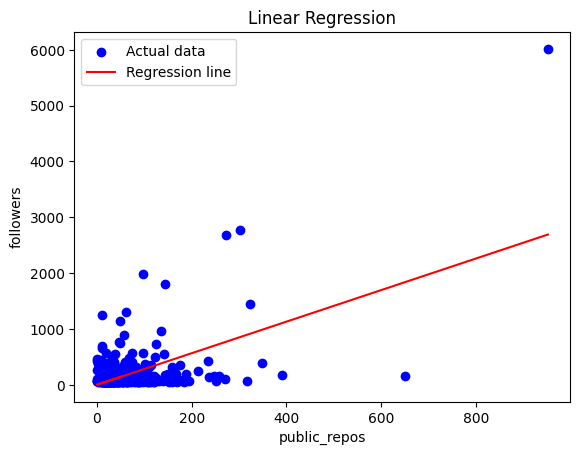

Regression equation: y = 2.199593908598674 + 2.824888128792011*X1


<ipython-input-30-de8d82d32d31>:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Regression equation: y = {model.params[0]} + {model.params[1]}*X1")


In [ ]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

# Assuming your DataFrame is called df and your variables are called 'X1' and 'y'
X = users_df['public_repos']  # Predictor variable
y = users_df['followers']  # Response variable

# Add a constant to the predictor variable
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the regression results
print(model.summary())

# Predict the y values based on the regression model
y_pred = model.predict(X)

# Plot the actual data points
plt.scatter(users_df['public_repos'], y, color='blue', label='Actual data')

# Plot the regression line
plt.plot(users_df['public_repos'], y_pred, color='red', label='Regression line')

# Add labels and title
plt.xlabel('public_repos')
plt.ylabel('followers')
plt.title('Linear Regression')
plt.legend()

# Display the plot
plt.show()

# Print the equation of the regression line
print(f"Regression equation: y = {model.params[0]} + {model.params[1]}*X1")

In [ ]:
from scipy.stats import pearsonr

repos_df['has_projects'] = repos_df['has_projects'].astype(int)
repos_df['has_wiki'] = repos_df['has_wiki'].astype(int)

x = repos_df['has_projects']
y = repos_df['has_wiki']

correlation = y.corr(x)

print(f"Correlation between var1 and var2: {correlation}")

Correlation between var1 and var2: 0.3358066191032218


In [ ]:
repos_df['created_at'] = pd.to_datetime(repos_df['created_at'])

# Extract the day of the week (0 = Monday, 6 = Sunday)
repos_df['day_of_week'] = repos_df['created_at'].dt.dayofweek

# Identify weekends (Saturday=5, Sunday=6)
weekend_df = repos_df[repos_df['day_of_week'].isin([5, 6])]

# Count the number of repos created by each user on weekends
weekend_counts = weekend_df['login'].value_counts()

# Get the top 5 users who created the most repos on weekends
top_5_users = weekend_counts.head(5)

print("Top 5 users who created the most repos on weekends:")
print(top_5_users)

Top 5 users who created the most repos on weekends:
login
kracekumar    47
skilbjo       44
aldanor       40
wafuwafu13    39
butlerx       37
Name: count, dtype: int64


In [ ]:
users_df = users_df.dropna(subset=['name'])

# Trim whitespace from names
users_df['name'] = users_df['name'].str.strip()

# Split names by whitespace and get the last word as the surname
users_df['surname'] = users_df['name'].apply(lambda x: x.split()[-1] if len(x.split()) > 1 else None)

# Drop rows with None values in 'surname'
users_df = users_df.dropna(subset=['surname'])

# Count the occurrences of each surname
surname_counts = users_df['surname'].value_counts()

# Get the most common surname
max_count = surname_counts.max()
most_common_surnames = surname_counts[surname_counts == max_count].index.tolist()

print(f"The most common surnames with {max_count} occurrences are: {', '.join(most_common_surnames)}")

The most common surnames with 3 occurrences are: Quinn, Kenny, Chen, O'Sullivan


In [ ]:
import pandas as pd

# Step 1: Ensure 'hireable' column is boolean
users_df['hireable'] = users_df['hireable'].fillna(False).astype(bool)

# Step 2: Calculate the average following for both groups
avg_following_hireable = users_df[users_df['hireable']]['followers'].mean()
avg_following_non_hireable = users_df[~users_df['hireable']]['followers'].mean()

# Step 3: Calculate the difference in average following
difference = avg_following_hireable - avg_following_non_hireable

# Display the results
print(f"Average following (Hireable=True): {avg_following_hireable}")
print(f"Average following (Hireable=False): {avg_following_non_hireable}")
print(f"Difference in average following: {difference}")

Average following (Hireable=True): 186.8901098901099
Average following (Hireable=False): 169.12542372881356
Difference in average following: 17.76468616129634


<ipython-input-32-f8ad23eef450>:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  users_df['hireable'] = users_df['hireable'].fillna(False).astype(bool)


In [ ]:
import statsmodels.api as sm
from scipy.stats import linregress


users_df = users_df.dropna(subset=['bio'])

# Calculate the word count of each bio
users_df['bio_word_count'] = users_df['bio'].apply(lambda x: len(x.split()))

# Perform linear regression using scipy
x = users_df['bio_word_count']
y = users_df['followers']

slope, intercept, r_value, p_value, std_err = linregress(x, y)

print(f"Regression slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard error: {std_err}")

Regression slope: 7.239143195391811
Intercept: 125.51733474980968
R-squared: 0.013512732030941369
P-value: 0.03620165683424431
Standard error: 3.4415974099669064


In [ ]:
# Calculate the average number of people followed by hireable users
average_following_hireable = users_df[users_df['hireable'] == True]['following'].mean()

# Calculate the average number of people followed by non-hireable users (including NaN)
average_following_non_hireable = users_df[users_df['hireable'] != True]['following'].mean()

# Calculate the difference
difference = average_following_hireable - average_following_non_hireable

print("Average following per hireable user:", average_following_hireable)
print("Average following per non-hireable user:", average_following_non_hireable)
print("Difference:", difference)

Average following per hireable user: 112.81318681318682
Average following per non-hireable user: 65.51864406779661
Difference: 47.2945427453902


In [ ]:
hireable_users = users_df[users_df['hireable'] == True]
non_hireable_users = users_df[users_df['hireable'] != True]

# Calculate fractions
fraction_hireable_with_email = hireable_users['email'].notna().mean() if not hireable_users.empty else 0
fraction_non_hireable_with_email = non_hireable_users['email'].notna().mean() if not non_hireable_users.empty else 0

# Compute the difference
difference = fraction_hireable_with_email - fraction_non_hireable_with_email

print("Fraction of hireable users with email:", fraction_hireable_with_email)
print("Fraction of non-hireable users with email:", fraction_non_hireable_with_email)
print("Difference:", difference)

Fraction of hireable users with email: 0.5604395604395604
Fraction of non-hireable users with email: 0.45084745762711864
Difference: 0.1095921028124418
